In [107]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, RocCurveDisplay

In [108]:
data = np.load('processed_ntuples\chunk_data.npy')
np.shape(data)

(529663, 33)

In [109]:
train, val = train_test_split(data, random_state=137) # setting the seed for reproducibility; the default train/test split is 0.75/0.25
print('lenght of training set', len(train), '\nlenght of validation set', len(val), '\nwidth of the sets: # of features + 1 flag (1-LL/0-TX)', len(train[0]))

lenght of training set 397247 
lenght of validation set 132416 
width of the sets: # of features + 1 flag (1-LL/0-TX) 33


In [110]:
# strip the last feature (e.g. the flag) from the sets

# copy in dedicated arrays
flags_train = train[:, -1]
flags_val = val[:, -1]
# delete from the sets
train = train[:, :-1]
val = val[:, :-1]
# width check
print(len(train[0]), len(val[0]))

32 32


In [111]:
# tensorize the data, so that pytorch doesn't whine
train = torch.tensor(train, dtype=torch.float32)
val = torch.tensor(val, dtype=torch.float32)
flags_train = torch.tensor(flags_train, dtype=torch.float32)
flags_val = torch.tensor(flags_val, dtype=torch.float32)

In [112]:
# creation of the model class
# (don't know if the sigmoid is defined in the best way possibile; this one just works)
sigmoid = nn.Sigmoid()
class myModel(nn.Module):
    def __init__(self):
        super(myModel, self).__init__()
        self.dense1 = nn.Linear(32, 128)
        self.relu1 = nn.ReLU()
        self.dense2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        self.dense3 = nn.Linear(64, 1)
    def forward(self, x):
        x = self.dense1(x)
        x = self.relu1(x)
        x = self.dense2(x)
        x = self.relu2(x)
        x = self.dense3(x)
        x = sigmoid(x)
        return x

In [113]:
model = myModel()

loss_function = nn.BCELoss() # CrossEntropyLoss but for just one class
learning_rate = 1.e-2
optimizer = optim.Adam(model.parameters(), lr=learning_rate) # how much the learning rate matter? the default one is 0.001

In [114]:
# training
losses = []
val_losses = []
n_epochs = 250
for epoch in range(n_epochs):
    outputs = model(train)

    loss = loss_function(outputs, flags_train.unsqueeze(0).T)
    losses.append(loss)

    with torch.no_grad():
        val_outputs = model(val)
        val_loss = loss_function(val_outputs, flags_val.unsqueeze(0).T)
        val_losses.append(val_loss)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    predicted = torch.round(outputs)
    accuracy = (predicted.T == flags_train).float().mean()

    if epoch % (n_epochs//5) == 0: print(f'Epoch: {epoch}, Accuracy: {accuracy.item():.3f}, Loss: {loss.item():.3f}, Validation Loss: {val_loss.item():.3f}, Learning Rate: {optimizer.param_groups[0]["lr"]}')

Epoch: 0, Accuracy: 0.325, Loss: 0.718, Validation Loss: 0.718, Learning Rate: 0.01
Epoch: 50, Accuracy: 0.712, Loss: 0.573, Validation Loss: 0.573, Learning Rate: 0.01
Epoch: 100, Accuracy: 0.740, Loss: 0.530, Validation Loss: 0.533, Learning Rate: 0.01
Epoch: 150, Accuracy: 0.764, Loss: 0.487, Validation Loss: 0.493, Learning Rate: 0.01
Epoch: 200, Accuracy: 0.788, Loss: 0.451, Validation Loss: 0.459, Learning Rate: 0.01


In [115]:
# transform the tensors to numpy for plotting
losses = np.array([l.detach().numpy() for l in losses])
val_losses = np.array([l.detach().numpy() for l in val_losses])

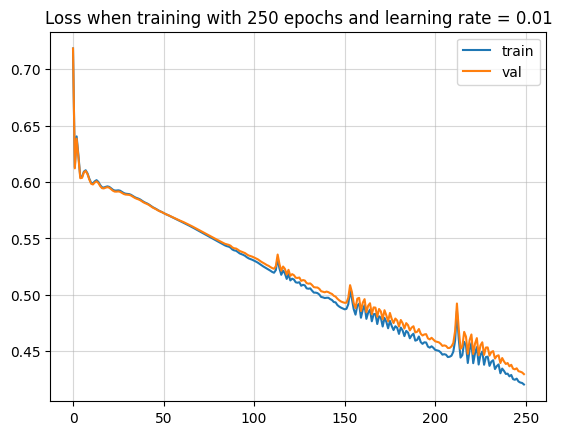

In [116]:
plt.plot(list(range(n_epochs)), losses, label='train')
plt.plot(list(range(n_epochs)), val_losses, label='val')
plt.title(f'Loss when training with {n_epochs} epochs and learning rate = {learning_rate}')
plt.grid(alpha=0.5)
plt.legend()
plt.savefig(f'loss_3Layers_{n_epochs}_{learning_rate}.png')

In [117]:
# transform the tensors to numpy for plotting
val_outputs = val_outputs.detach().numpy()
flags_val = flags_val.detach().numpy()

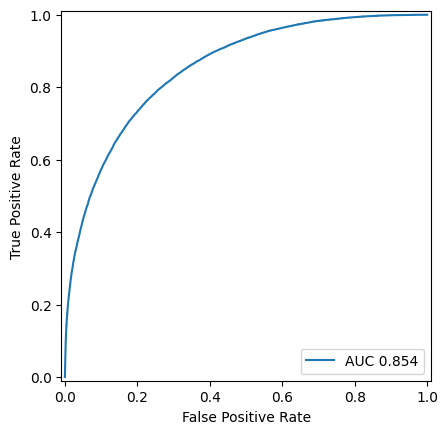

In [118]:
fpr, tpr, thresholds = roc_curve(flags_val, val_outputs)

auc = roc_auc_score(flags_val, val_outputs)

# Create the ROC curve display
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, estimator_name=f'AUC {auc:.3f}')

# Plot the ROC curve
roc_display.plot()

plt.savefig(f'ROC_3Layers_{n_epochs}_{learning_rate}.png')

In [119]:
sig = val_outputs[flags_val.T.astype(bool)]
bkg = val_outputs[~flags_val.T.astype(bool)]

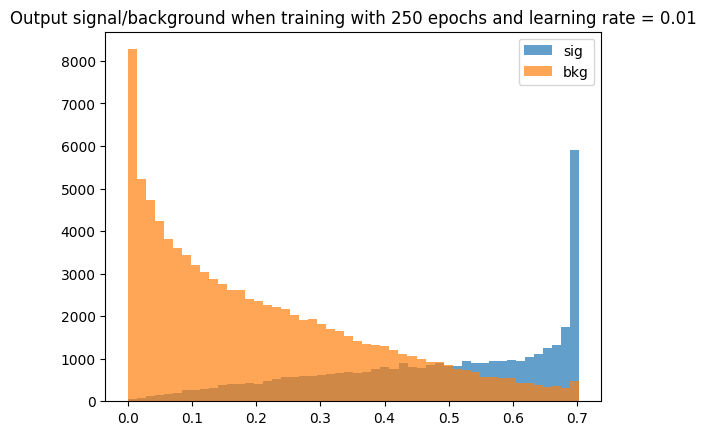

In [120]:
plt.hist(sig, bins=50, alpha=0.7, label='sig')
plt.hist(bkg, bins=50, alpha=0.7, label='bkg')
plt.title(f'Output signal/background when training with {n_epochs} epochs and learning rate = {learning_rate}')
plt.legend()
plt.savefig(f'output_3Layers_{n_epochs}_{learning_rate}.png')

In [121]:
#